In [1]:
#Import Libraries
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LogisticRegressionCV,LassoCV,ElasticNet,ElasticNetCV,RidgeCV,RidgeClassifierCV,ridge_regression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score,cross_val_predict,RepeatedStratifiedKFold,RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
#need "pip install scikit-optimize"
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize
from timeit import default_timer as timer
from sklearn import tree
import graphviz
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#all the regression models
def graph_result(X,Y_test,Y_pred):
    x_ax = range(len(X))
    plt.scatter(x_ax, Y_test, s=5, color="navy", label="original")
    plt.plot(x_ax, Y_pred, lw=0.8, color="gold", label="predicted")
    plt.legend()
    plt.show()
    return()

def run_linear(X,Y,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'fit_intercept' : [True,False],
        'positive' : [True,False]
    }    
    cv = KFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=LinearRegression(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=10,
        #scoring="accuracy",  -- leave as default which is based on the estimator
        verbose=0,
        random_state=5440
    )
    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
    search.fit(x_scaled,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)   

    model = LinearRegression(n_jobs=-1,fit_intercept=best_params['fit_intercept'],positive=best_params['positive'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)
    
# function for fitting trees of various depths for Random Forests
def run_cross_validation_on_regression_RF(X, Y):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [200, 400, 600, 800, 1000],
        'max_depth': (1, 9),
        'criterion': ['squared_error'],
        'max_features' : [.250,.3333,.375]
    }
    cv = KFold(n_splits = 5,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=RandomForestRegressor(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=100,
        #scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],max_features=best_params['max_features'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)    
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    return(rmse_test,r2_test)

# function for fitting trees of various depths for Boosted Version
def run_cross_validation_on_regression_Boost(X, Y):
    #X = predictors, Y = response
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [500, 600, 700, 800, 900, 1000],
        'max_depth': (1, 9),
        'criterion': ['friedman_mse','squared_error'],
        'loss' : ['squared_error','huber'],
        'max_features' : ['sqrt','log2']
    }    
    cv = KFold(n_splits = 5,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=GradientBoostingRegressor(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=150,
        #scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],loss=best_params['loss'],max_features=best_params['max_features'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    return(rmse_test,r2_test)

#enet regression:  handles E-Net and Lasso
def run_enet_regression(X,Y,graph=False,iter_nbr=1000):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'alpha' : [.001,.01,.1,1.0,10.0,100.0,110.0],
        'l1_ratio' : [.01,.05,.1,.3,.5,.7,.9,.95,.99,1],
        'fit_intercept' : [True,False]
    }    
    cv = KFold(n_splits = 5,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=ElasticNet(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=175,
        #scoring="accuracy",  -- leave as default which is based on the estimator
        verbose=0,
        random_state=5440
    )
    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
    search.fit(x_scaled,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)   

    model = ElasticNet(fit_intercept=best_params['fit_intercept'],alpha=best_params['alpha'],
                         l1_ratio=best_params['l1_ratio'],random_state=5440)
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)

#ridge regression:  handles Ridge separately due to different hyperparameters and lack of feature selection
def run_ridge_regression(X,Y,graph=False,iter_nbr=1000):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression

    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
   
    cv = RepeatedKFold(n_splits = 5,n_repeats=75,random_state=5440)  
    model = RidgeCV(alphas=[.0001,.0005,.001,.005,.01,.05,.1,.5,1.0,5,10,50,100],cv=cv)
    model.fit(x_scaled,Y)
    print(model.alpha_)
    
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)   

    pred_test = model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)

In [3]:
#models used for classification
def run_logistic(X,Y,graph=False,iter_nbr=100):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'fit_intercept' : [True,False],
        'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }    
    cv = StratifiedKFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=LogisticRegressionCV(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=50,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
    search.fit(x_scaled,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)
    model = LogisticRegressionCV(cv=cv,fit_intercept=best_params['fit_intercept']
                                 ,solver=best_params['solver'],scoring='accuracy',max_iter=iter_nbr,n_jobs=-1)
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='Greys')
        plt.show()

    return(test_score)

# function for fitting trees of various depths using cross-validation
def run_cross_validation_on_classification_RF(X, Y,scoring='accuracy',iter_nbr=500,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [200, 400, 600, 800,  1000],
        'max_depth': (1, 9),
        'criterion': ['gini', 'entropy'],
        'max_features' : ['sqrt','log2']
    }   
    cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=125,     
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],max_features=best_params)
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='Greys')
        plt.show()

    return(test_score)

def run_cross_validation_on_classification_Boost(X, Y,scoring='accuracy',iter_nbr=500,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [500, 750, 1000, 1250, 1500],
        'max_depth': (1, 9),
        'criterion': ['friedman_mse', 'squared_error'],
        'max_features' : ['sqrt','log2']
    } 
    cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=GradientBoostingClassifier(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=150,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = GradientBoostingClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],max_features=best_params['max_features'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='Greys')
        plt.show()

    return(test_score)

#RDA is Regularized Discriminant Analysis (similar to how elastic-net works with Lasso and Ridge)
def run_RDA_classification(X,Y,graph=False):
    #X = predictors, Y = response, other numbers for the range of values
    
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search
    hyper_params = {
        'solver' : ['lsqr','eigen'],
        'shrinkage' : np.arange(0,1.005,.005)
    }
    cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=LinearDiscriminantAnalysis(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=200,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    #find the hyperparameters on all the data and capture them for use for training and testing
    search.fit(X,Y)    
    best_params = search.best_params_
    
    #scale the X values for consistency (though may not have much effect for LDA as it would knn, PCA, gradient decent and ridge/Lasso...)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)
    model = LinearDiscriminantAnalysis(shrinkage=best_params['shrinkage'],solver=best_params['solver'])   
    model.fit(x_train,y_train)
    print(best_params)    
     
    #find the worth of the model  
    pred_test = cross_val_predict(model,x_test,y_test,cv=5,n_jobs=-1)
    pred_score = cross_val_score(model,x_test,y_test,cv=5,n_jobs=-1)
    
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='Greys')
        plt.show()

    return(pred_score.mean())

In [4]:
#other functions
#function to handle multi-collinearity tests
def vif_calc(X):
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_info['Column'] = X.columns
    vif_info.sort_values('VIF', ascending=False)
    return(vif_info)

#function to pass back AIC for linear model

def aic_calc(X,Y):
    #add constant to predictor variables
    X = sm.add_constant(X)
    #fit regression model
    model = sm.OLS(Y, X).fit()
    return(model.aic)


In [5]:
#load the soybean dataset into a dataframe and confirm values
full_start = timer()
df_soy_raw = pd.read_csv('DataSets\\Soybean_Daily_Tickets_With_Price.csv')
df_soy_raw.head(12)

,commodity_code,delivery_commodity_count,Diff_from_average_amt,delivery_commodity_count_avg,Diff_from_average_category,open_price,close_price,max_price,min_price,prior_day_open_price,...,recent_avg_price_diff,recent_avg_trend,prior_day_open_diff,prior_day_trend,prior_2_day_open_diff,prior_2_day_trend,prior_3_day_open_diff,prior_3_day_trend,yesterday_avg_diff,yesterday_avg_trend
0,8,2,0.0,2.0,Average,13.680,13.6050,13.6800,13.470,13.5980,...,0.3367,Significantly Better (>.10),0.0825,Better (>.05),0.4875,Significantly Better (>.10),0.4400,Significantly Better (>.10),0.3813,Significantly Better (>.10)
1,8,1,0.0,1.0,Average,9.315,9.3500,9.3550,9.275,9.4325,...,-0.0617,Worse (<-.05),-0.1175,Significantly Worse (<-.10),-0.0475,Slightly Worse (<-.02),-0.0200,Slightly Worse (<-.02),0.0838,Better (>.05)
2,8,2,0.0,2.0,Average,10.000,9.9575,10.0200,9.890,9.9450,...,0.0722,Better (>.05),0.0550,Better (>.05),0.0775,Better (>.05),0.0842,Better (>.05),0.0258,Slightly Better (>.02)
3,8,1,0.0,1.0,Average,14.950,14.8750,14.9500,14.770,14.8800,...,0.1136,Significantly Better (>.10),0.0700,Better (>.05),0.1125,Significantly Better (>.10),0.1583,Significantly Better (>.10),0.0654,Better (>.05)
4,8,1,0.0,1.0,Average,8.910,8.9625,8.9975,8.885,8.8550,...,0.0625,Better (>.05),0.0550,Better (>.05),0.0525,Better (>.05),0.0800,Better (>.05),0.0113,Nominal Change
5,8,3,-8.5,11.5,Average,14.500,14.4780,14.5900,14.363,14.6130,...,-0.1983,Significantly Worse (<-.10),-0.1125,Significantly Worse (<-.10),-0.1983,Significantly Worse (<-.10),-0.2842,Significantly Worse (<-.10),-0.1288,Significantly Worse (<-.10)
6,8,20,8.5,11.5,Average,8.600,8.5500,8.6250,8.545,8.6700,...,-0.1208,Significantly Worse (<-.10),-0.0700,Worse (<-.05),-0.0925,Worse (<-.05),-0.2000,Worse (<-.05),-0.0763,Worse (<-.05)
7,8,4,0.5,3.5,Average,12.915,12.9380,12.9500,12.765,12.8770,...,0.0767,Better (>.05),0.0383,Slightly Better (>.02),0.0767,Better (>.05),0.1150,Better (>.05),0.0575,Better (>.05)
8,8,3,-0.5,3.5,Average,10.155,10.1100,10.1850,10.060,10.1440,...,0.0217,Slightly Better (>.02),0.0108,Nominal Change,0.0217,Slightly Better (>.02),0.0325,Slightly Better (>.02),0.0163,Nominal Change
9,8,3,-6.5,9.5,Average,13.010,13.0530,13.0700,12.915,12.9150,...,0.1333,Significantly Better (>.10),0.0950,Better (>.05),0.1333,Significantly Better (>.10),0.1717,Significantly Better (>.10),0.0575,Better (>.05)


In [6]:
#Load the corn dataset into a dataframe and confirm the values
df_corn_raw = pd.read_csv('DataSets\\Corn_Daily_Tickets_With_Price.csv')
df_corn_raw.head(12)

,commodity_code,delivery_commodity_count,Diff_from_average_amt,delivery_commodity_count_avg,Diff_from_average_category,open_price,close_price,max_price,min_price,prior_day_open_price,...,recent_avg_price_diff,recent_avg_trend,prior_day_open_diff,prior_day_trend,prior_2_day_open_diff,prior_2_day_trend,prior_3_day_open_diff,prior_3_day_trend,yesterday_avg_diff,yesterday_avg_trend
0,9,1,0.00,1.000000,Average,3.8325,3.8575,3.8675,3.7650,3.8375,...,-0.0100,Nominal Change,-0.0050,Nominal Change,-0.0075,Nominal Change,-0.0175,Nominal Change,-0.0075,Nominal Change
1,9,1,0.00,1.000000,Average,6.3900,6.4250,6.4950,6.3325,6.3100,...,0.2433,Significantly Better (>.10),0.0800,Better (>.05),0.3100,Significantly Better (>.10),0.3400,Significantly Better (>.10),0.2450,Significantly Better (>.10)
2,9,1,0.00,1.000000,Average,6.5500,6.5525,6.6150,6.5050,6.5567,...,-0.0133,Nominal Change,-0.0067,Nominal Change,-0.0133,Nominal Change,-0.0200,Nominal Change,-0.0100,Nominal Change
3,9,2,0.00,2.000000,Average,3.6950,3.6950,3.7275,3.6750,3.6800,...,0.0425,Slightly Better (>.02),0.0150,Nominal Change,0.0575,Better (>.05),0.0550,Better (>.05),0.0413,Slightly Better (>.02)
4,9,12,0.00,12.000000,Average,3.5975,3.5550,3.6150,3.5500,3.6200,...,-0.0542,Worse (<-.05),-0.0225,Slightly Worse (<-.02),-0.0725,Worse (<-.05),-0.0675,Worse (<-.05),-0.0475,Slightly Worse (<-.02)
5,9,2,-26.50,28.500000,Below_Average,6.9350,7.0500,7.0575,6.9175,6.9000,...,0.0283,Slightly Better (>.02),0.0350,Slightly Better (>.02),0.0283,Slightly Better (>.02),0.0217,Slightly Better (>.02),-0.0100,Nominal Change
6,9,55,26.50,28.500000,Above_Average,3.5550,3.5450,3.5625,3.5250,3.5975,...,-0.0742,Worse (<-.05),-0.0425,Slightly Worse (<-.02),-0.0650,Worse (<-.05),-0.1150,Worse (<-.05),-0.0475,Slightly Worse (<-.02)
7,9,10,-3.33,13.333333,Average,6.4350,6.4450,6.4575,6.3300,6.4133,...,0.0433,Slightly Better (>.02),0.0217,Slightly Better (>.02),0.0433,Slightly Better (>.02),0.0650,Slightly Better (>.02),0.0325,Slightly Better (>.02)
8,9,12,-1.33,13.333333,Average,7.0500,7.0950,7.1125,7.0250,6.9350,...,0.1361,Significantly Better (>.10),0.1150,Significantly Better (>.10),0.1500,Significantly Better (>.10),0.1433,Significantly Better (>.10),0.0317,Slightly Better (>.02)
9,9,18,4.67,13.333333,Average,3.6425,3.6025,3.6550,3.5950,3.6475,...,-0.0100,Nominal Change,-0.0050,Nominal Change,-0.0100,Nominal Change,-0.0150,Nominal Change,-0.0075,Nominal Change


Response variables are Diff_from_average_amt (regression) and Diff_from_average_category (classification)

Prep both corn and soybean datasets and create both a "full" and "partial"

In [7]:
df_soy = df_soy_raw.copy()
df_corn = df_corn_raw.copy()

#drop fields not needed for analysis
df_soy = df_soy.drop(['commodity_code','delivery_commodity_count','delivery_commodity_count_avg'],axis=1)
df_corn = df_corn.drop(['commodity_code','delivery_commodity_count','delivery_commodity_count_avg'],axis=1)

#create full data sets for each type of analysis
ys_reg = df_soy['Diff_from_average_amt']
ys_class = df_soy['Diff_from_average_category']
xs_full = df_soy.drop(['Diff_from_average_category','Diff_from_average_amt'],axis=1)
xs_full = pd.get_dummies(xs_full,drop_first = True) #make dummies for categorical values

yc_reg = df_corn['Diff_from_average_amt']
yc_class = df_corn['Diff_from_average_category']
xc_full = df_corn.drop(['Diff_from_average_category','Diff_from_average_amt'],axis=1)
xc_full = pd.get_dummies(xc_full,drop_first = True) #make dummies for categorical values

In [8]:
#take a look  at the vif calcuations for soybeans
vif_calc(xs_full)
#remove infinite values
xs_part = xs_full.drop(['prior_2_day_trend_Nominal Change','prior_2_day_trend_Significantly Better (>.10)','prior_2_day_trend_Significantly Worse (<-.10)','prior_2_day_trend_Slightly Better (>.02)','prior_2_day_trend_Slightly Worse (<-.02)','prior_2_day_trend_Worse (<-.05)','prior_3_day_trend_Nominal Change','prior_3_day_trend_Significantly Better (>.10)','prior_3_day_trend_Significantly Worse (<-.10)','prior_3_day_trend_Slightly Better (>.02)','prior_3_day_trend_Slightly Worse (<-.02)','prior_3_day_trend_Worse (<-.05)'],axis=1)
vif_calc(xs_part)


,VIF,Column
0,2.983324e+09,open_price
1,2.360417e+04,close_price
2,3.146889e+04,max_price
3,3.084581e+04,min_price
4,3.098498e+09,prior_day_open_price
5,3.842165e+09,prior_2_day_open_price
6,2.892944e+09,prior_3_day_open_price
7,3.258452e+09,recent_avg_price
8,4.398538e+07,recent_avg_price_diff
9,1.570947e+07,prior_day_open_diff


This is quite interesting in that there are either numbers under 10 or numbers over 16 million.  Sine I know the recent price is the average of the prior day open prices, I will remove the 6 "prior" fields to see how it shakes out.

In [9]:
#remove
xs_part = xs_part.drop(['prior_day_open_price','prior_2_day_open_price','prior_3_day_open_price','prior_day_open_diff','prior_2_day_open_diff','prior_3_day_open_diff'],axis=1)
vif_calc(xs_part)

# take a look at correlation to see which ones should go next
#run a correlation test on the high ones to see what make sense to keep
xs_temp = df_soy[['Diff_from_average_amt','open_price','close_price','max_price','min_price','recent_avg_price','recent_avg_price_diff']]
corr = xs_temp.corr()
corr.style.background_gradient(cmap='coolwarm')

#according to the corrlation, I am going to keep open price and remove close/max/min and the recent average (in favor of diff)
xs_part = xs_part.drop(['max_price','close_price','min_price'],axis=1)
vif_calc(xs_part)

#run a correlation test on the high ones to see what make sense to keep
xs_temp = df_soy[['Diff_from_average_amt','open_price','recent_avg_price','recent_avg_price_diff']]
corr = xs_temp.corr()
corr.style.background_gradient(cmap='coolwarm')

#do aic checks on the one I should remove
aic_val =np.empty(4)
aic_val[0] = aic_calc(xs_part,ys_reg)
temp_x = xs_part.drop(['open_price'],axis=1)
aic_val[1] = aic_calc(temp_x,ys_reg)
temp_x = xs_part.drop(['recent_avg_price'],axis=1)
aic_val[2] = aic_calc(temp_x,ys_reg)
temp_x = xs_part.drop(['recent_avg_price_diff'],axis=1)
aic_val[3] = aic_calc(temp_x,ys_reg)
print(aic_val)

#looks like enough of the open price is found in the average price for the prior 3 days.  Vif is still above 10 but not too bad.
xs_part = xs_part.drop(['open_price'],axis=1)
vif_calc(xs_part)


[22229.73698809 22228.17234377 22228.17034121 22228.171763  ]


,VIF,Column
0,12.463547,recent_avg_price
1,7.370476,recent_avg_price_diff
2,7.529689,yesterday_avg_diff
3,2.707760,recent_avg_trend_Nominal Change
4,3.958342,recent_avg_trend_Significantly Better (>.10)
5,9.435674,recent_avg_trend_Significantly Worse (<-.10)
6,1.803613,recent_avg_trend_Slightly Better (>.02)
7,2.519132,recent_avg_trend_Slightly Worse (<-.02)
8,3.752933,recent_avg_trend_Worse (<-.05)
9,3.742457,prior_day_trend_Nominal Change


In [10]:
#now do the same for corn

vif_calc(xc_full)
#remove infinite values

xc_part = xc_full.drop(['prior_2_day_trend_Nominal Change','prior_2_day_trend_Significantly Better (>.10)','prior_2_day_trend_Significantly Worse (<-.10)','prior_2_day_trend_Slightly Better (>.02)','prior_2_day_trend_Slightly Worse (<-.02)','prior_2_day_trend_Worse (<-.05)','prior_3_day_trend_Nominal Change','prior_3_day_trend_Significantly Better (>.10)','prior_3_day_trend_Significantly Worse (<-.10)','prior_3_day_trend_Slightly Better (>.02)','prior_3_day_trend_Slightly Worse (<-.02)','prior_3_day_trend_Worse (<-.05)'],axis=1)
vif_calc(xc_part)
#remove since they are a part of recent
xc_part = xc_part.drop(['prior_day_open_price','prior_2_day_open_price','prior_3_day_open_price','prior_day_open_diff','prior_2_day_open_diff','prior_3_day_open_diff'],axis=1)
vif_calc(xc_part)

xc_temp = df_corn[['Diff_from_average_amt','open_price','close_price','max_price','min_price','recent_avg_price','recent_avg_price_diff']]
corr = xc_temp.corr()
corr.style.background_gradient(cmap='coolwarm')

#according to the corrlation, close_price is more related to corn than open
xc_part = xc_part.drop(['max_price','open_price','min_price'],axis=1)
vif_calc(xc_part)

#do aic checks on the one I should remove
aic_val =np.empty(4)
aic_val[0] = aic_calc(xc_part,yc_reg)
temp_x = xc_part.drop(['close_price'],axis=1)
aic_val[1] = aic_calc(temp_x,yc_reg)
temp_x = xc_part.drop(['recent_avg_price'],axis=1)
aic_val[2] = aic_calc(temp_x,yc_reg)
temp_x = xc_part.drop(['recent_avg_price_diff'],axis=1)
aic_val[3] = aic_calc(temp_x,yc_reg)
print(aic_val)

#AIC tells us that dropping recent_avg_price produces the best results.  Surprised.... Highest vif is around 10 so we are good.
xc_part = xc_part.drop(['recent_avg_price'],axis=1)
vif_calc(xc_part)



[23908.39418097 23907.23657573 23907.22117426 23908.98467761]


,VIF,Column
0,10.133898,close_price
1,8.785319,recent_avg_price_diff
2,8.324484,yesterday_avg_diff
3,6.347819,recent_avg_trend_Nominal Change
4,3.117076,recent_avg_trend_Significantly Better (>.10)
5,8.707889,recent_avg_trend_Significantly Worse (<-.10)
6,2.991629,recent_avg_trend_Slightly Better (>.02)
7,5.504175,recent_avg_trend_Slightly Worse (<-.02)
8,6.772942,recent_avg_trend_Worse (<-.05)
9,7.594945,prior_day_trend_Nominal Change


In [11]:
#Soybeans Regression
# With the regression functions defined, run the regressions and capture the RMSE and R-squared
start = timer()
linear_rmse,linear_r2 = run_linear(xs_part,ys_reg)
end = timer()
print(f'Linear Model on Data Subset Complete in {end-start} seconds')

start = timer()      
enet_full_rmse,enet_full_r2 = run_enet_regression(xs_full,ys_reg)
end = timer()
print(f'Enet Regression Model on Full Dataset Complete in {end-start} seconds')

start = timer()  
ridge_part_rmse,ridge_part_r2 = run_ridge_regression(xs_part,ys_reg)
end = timer()
print(f'Ridge Regression Model on Data Subset Complete in {end-start} seconds')

start = timer()  
rfr_rmse,rfr_r2 = run_cross_validation_on_regression_RF(xs_part,ys_reg)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()  
boost_rmse,boost_r2 = run_cross_validation_on_regression_Boost(xs_full,ys_reg)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()  
boost_part_rmse,boost_part_r2 = run_cross_validation_on_regression_Boost(xs_part,ys_reg)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

OrderedDict([('fit_intercept', False), ('positive', False)])
Linear Model on Data Subset Complete in 4.1002301 seconds
OrderedDict([('alpha', 1.0), ('fit_intercept', False), ('l1_ratio', 0.3)])
Enet Regression Model on Full Dataset Complete in 560.4871969 seconds
100.0
Ridge Regression Model on Data Subset Complete in 4.467145500000015 seconds
OrderedDict([('criterion', 'squared_error'), ('max_depth', 4), ('n_estimators', 200)])
Random Forest Model on Data Subset Complete in 1017.887733 seconds
OrderedDict([('criterion', 'friedman_mse'), ('loss', 'squared_error'), ('max_depth', 1), ('max_features', 'sqrt'), ('n_estimators', 500)])
Boosted Trees Model on Full Dataset Complete in 571.5379677999999 seconds
OrderedDict([('criterion', 'squared_error'), ('loss', 'squared_error'), ('max_depth', 1), ('max_features', 'log2'), ('n_estimators', 500)])
Boosted Trees Model on Data Subset Complete in 553.8900981000002 seconds


In [12]:
#Soybeans Regression results
result_ds_list  = [['Linear Run 1','Subset',linear_rmse,linear_r2]
                  ,['ENet Run 1','Full',enet_full_rmse,enet_full_r2]
                  ,['Ridge Run 1','Subset',ridge_part_rmse,ridge_part_r2]
                  ,['Random Forest Run 1','Subset',rfr_rmse,rfr_r2]
                  ,['Boosted Trees Run 1','Full',boost_rmse,boost_r2]
                  ,['Boosted Trees Run 2','Subset',boost_part_rmse,boost_part_r2]]
results_delivery_count = pd.DataFrame(result_ds_list,columns=['Model','Dataset','RMSE','R^2'])
results_delivery_count.sort_values(['RMSE','R_Squared'],ascending=[True,False])

,Model_Name,Data_Used,RMSE,R_Squared
4,Boosted Trees Run 1,Full,55.976456,0.171250
5,Boosted Trees Run 2,Subset,56.718226,0.149140
3,Random Forest Run 1,Subset,56.919788,0.143082
2,Ridge Run 1,Subset,58.592939,0.091963
0,Linear Run 1,Subset,59.088801,0.076529
1,ENet Run 1,Full,59.164919,0.074148


OrderedDict([('fit_intercept', False), ('solver', 'newton-cg')])


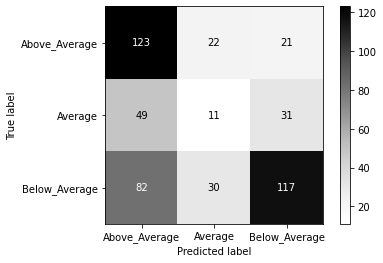

Logistic Model on Data Subset Complete in 80.36375789999965 seconds


In [ ]:
#Soybeans Classfication
start = timer()
log_accuracy_part = run_logistic(xs_part,ys_class,graph=True)
end = timer()
print(f'Logistic Model on Data Subset Complete in {end-start} seconds')

start = timer()
rda_accuracy_full = run_RDA_classification(xs_full,ys_class,graph=True)
end = timer()
print(f'RDA Model on Full Data Complete in {end-start} seconds')

start = timer()
rda_accuracy_part = run_RDA_classification(xs_part,ys_class,graph=True)
end = timer()
print(f'RDA Model on Data Subset Complete in {end-start} seconds')

start = timer()
rf_accuracy_part = run_cross_validation_on_classification_RF(xs_part,ys_class,graph=True)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()
boost_accuracy_full = run_cross_validation_on_classification_Boost(xs_full,ys_class,graph=True)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()
boost_accuracy_part = run_cross_validation_on_classification_Boost(xs_part,ys_class,graph=True)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

In [ ]:
#Soybeans Classification Results
#create a data frame of the results for analysis
result_aa_list  = [['Logistic Run 1','Partial',log_accuracy_part]
                  ,['RDA Run 1','Full',rda_accuracy_full]
                  ,['RDA Run 2','Partial',rda_accuracy_part]
                  ,['Random Forest Run 1','Partial',rf_accuracy_part]
                  ,['Boosted Trees Run 1','Full',boost_accuracy_full]
                  ,['Boosted Trees Run 2','Partial',boost_accuracy_part]]
results_above_average = pd.DataFrame(result_aa_list,columns=['Model','Dataset','Accuracy'])
results_above_average.sort_values(['Accuracy'],ascending=[False])

In [ ]:
#Corn Regression
# With the regression functions defined, run the regressions and capture the RMSE and R-squared
start = timer()
linear_rmse,linear_r2 = run_linear(xc_part,yc_reg)
end = timer()
print(f'Linear Model on Data Subset Complete in {end-start} seconds')

start = timer()      
enet_full_rmse,enet_full_r2 = run_enet_regression(xc_full,yc_reg)
end = timer()
print(f'Enet Regression Model on Full Dataset Complete in {end-start} seconds')

start = timer()  
ridge_part_rmse,ridge_part_r2 = run_ridge_regression(xc_part,yc_reg)
end = timer()
print(f'Ridge Regression Model on Data Subset Complete in {end-start} seconds')

start = timer()  
rfr_rmse,rfr_r2 = run_cross_validation_on_regression_RF(xc_part,yc_reg)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()  
boost_rmse,boost_r2 = run_cross_validation_on_regression_Boost(xc_full,yc_reg)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()  
boost_part_rmse,boost_part_r2 = run_cross_validation_on_regression_Boost(xc_part,yc_reg)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

In [ ]:
#Corn Regression results
c_result_ds_list  = [['Linear Run 1','Subset',linear_rmse,linear_r2]
                    ,['ENet Run 1','Full',enet_full_rmse,enet_full_r2]
                    ,['Ridge Run 1','Subset',ridge_part_rmse,ridge_part_r2]
                    ,['Random Forest Run 1','Subset',rfr_rmse,rfr_r2]
                    ,['Boosted Trees Run 1','Full',boost_rmse,boost_r2]
                    ,['Boosted Trees Run 2','Subset',boost_part_rmse,boost_part_r2]]
results_delivery_count = pd.DataFrame(c_result_ds_list,columns=['Model','Dataset','RMSE','R^2'])
results_delivery_count.sort_values(['RMSE','R_Squared'],ascending=[True,False])

In [ ]:
#Corn Classfication
start = timer()
log_accuracy_part = run_logistic(xc_part,yc_class,graph=True)
end = timer()
print(f'Logistic Model on Data Subset Complete in {end-start} seconds')

start = timer()
rda_accuracy_full = run_RDA_classification(xc_full,yc_class,graph=True)
end = timer()
print(f'RDA Model on Full Data Complete in {end-start} seconds')

start = timer()
rda_accuracy_part = run_RDA_classification(xc_part,yc_class,graph=True)
end = timer()
print(f'RDA Model on Data Subset Complete in {end-start} seconds')

start = timer()
rf_accuracy_part = run_cross_validation_on_classification_RF(xc_part,yc_class,graph=True)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()
boost_accuracy_full = run_cross_validation_on_classification_Boost(xc_full,yc_class,graph=True)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()
boost_accuracy_part = run_cross_validation_on_classification_Boost(xc_part,yc_class,graph=True)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

In [ ]:
#corn Classification Results
#create a data frame of the results for analysis
c_result_aa_list  = [['Logistic Run 1','Partial',log_accuracy_part]
                    ,['RDA Run 1','Full',rda_accuracy_full]
                    ,['RDA Run 2','Partial',rda_accuracy_part]
                    ,['Random Forest Run 1','Partial',rf_accuracy_part]
                    ,['Boosted Trees Run 1','Full',boost_accuracy_full]
                    ,['Boosted Trees Run 2','Partial',boost_accuracy_part]]
results_above_average = pd.DataFrame(c_result_aa_list,columns=['Model','Dataset','Accuracy'])
results_above_average.sort_values(['Accuracy'],ascending=[False])